# Application: new experiment

This notebook allows users to find specific genes in their experiment of interest using an existing VAE model

This notebook will generate a `generic_gene_summary_<experiment id>.tsv` file that contains a z-score per gene that indicates how specific a gene is the experiment in question.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ponyo import utils
from generic_expression_patterns_modules import process, new_experiment_process, stats, ranking

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


## User input

User needs to define the following in the [config file](../configs/config_new_experiment.tsv):

1. Template experiment. This is the experiment you are interested in studying
2. Training compendium used to train VAE, including unnormalized gene mapped version and normalized version
3. Scaler transform used to normalize the training compendium
4. Directory containing trained VAE model
5. Experiment id to label newly create simulated experiments

The user also needs to provide metadata files:
1. `<experiment id>_process_samples.tsv` contains 2 columns (sample ids, label that indicates if the sample is kept or removed). See [example](data/metadata/cis-gem-par-KU1919_process_samples.tsv). **Note: This file is not required if the user wishes to use all the samples in the template experiment file.**
2. `<experiment id>_groups.tsv` contains 2 columns: sample ids, group label to perform DE analysis. See [example](data/metadata/cis-gem-par-KU1919_groups.tsv)

In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_new_experiment.tsv")
)

params = utils.read_config(config_filename)

In [4]:
# Load config params

# Local directory to store intermediate files
local_dir = params['local_dir']

# Number of simulated experiments to generate
num_runs = params['num_simulated']

# Directory containing trained VAE model
vae_model_dir = params['vae_model_dir']

# Dimension of latent space used in VAE model
latent_dim = params['latent_dim']

# ID for template experiment
# This ID will be used to label new simulated experiments
project_id = params['project_id']

# Template experiment filename
template_filename = params['raw_template_filename']
processed_template_filename = params['processed_template_filename']

# Training dataset used for existing VAE model
mapped_compendium_filename = params['mapped_compendium_filename']

# Normalized compendium filename
normalized_compendium_filename = params['normalized_compendium_filename']

# Scaler transform used to scale compendium data into 0-1 range for training
scaler_filename = params['scaler_filename']

# Test statistic used to rank genes by
col_to_rank_genes = params['rank_genes_by']

In [5]:
# Load metadata files

# Load metadata file with processing information
sample_id_metadata_filename = os.path.join(
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv"
)

# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    "data",
    "metadata",
    f"{project_id}_groups.tsv"
)

In [6]:
# Output filename
gene_summary_filename = f"generic_gene_summary_{project_id}.tsv"

## Map template experiment to same space as compendium

TO DO: Consolidate these functions

In [7]:
# Template experiment needs to be of the form sample x gene
transposed_template_filename = "/home/alexandra/Documents/Data/Generic_expression_patterns/Costello_BladderCancer_ResistantCells_Counts_12-8-20_transposed.txt"

new_experiment_process.transpose_save(template_filename, transposed_template_filename)

In [8]:
# Check that the feature space matches between template experiment and VAE model.  
# (i.e. ensure genes in template and VAE model are the same).
mapped_template_experiment = new_experiment_process.compare_match_features(
    transposed_template_filename,
    mapped_compendium_filename
)
mapped_template_filename = transposed_template_filename

(72, 58528)
(49651, 17755)


In [9]:
# Scale template experiment to be within the same range as the
# normalized training dataset used for the VAE model
new_experiment_process.normalize_template_experiment(
    mapped_template_experiment,
    scaler_filename,
    processed_template_filename
)

## Simulate experiments based on template experiment

Embed template experiment into learned latent space and linearly shift template experiment to different locations of the latent space to create new experiments

In [10]:
# Simulate experiments based on template experiment
normalized_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)
processed_template_data = pd.read_csv(processed_template_filename, sep="\t", index_col=0, header=0)

for run_id in range(num_runs):
    new_experiment_process.embed_shift_template_experiment(
        normalized_data,
        processed_template_data,
        vae_model_dir,
        project_id,
        scaler_filename,
        local_dir,
        latent_dim,
        run_id
    )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## Process template and simulated experiments

* Remove samples not required for comparison
* Make sure ordering of samples matches metadata for proper comparison
* Make sure values are cast as integers if using DESeq
* Filter lowly expressed genes if using DESeq

In [11]:
if os.path.exists(sample_id_metadata_filename):
    stats.process_samples_for_DESeq(
        mapped_template_filename,
        sample_id_metadata_filename,
        metadata_filename,
        None,
        processed_template_filename
    )
    
    for i in range(num_runs):
        simulated_filename = os.path.join(
            local_dir,
            "pseudo_experiment",
            f"selected_simulated_data_{project_id}_{i}.txt"
        )
        stats.process_samples_for_DESeq(
        simulated_filename,
        sample_id_metadata_filename,
        metadata_filename
    )

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


## Differential expression analysis

TO DO: Add conditonal for which method limma vs DESeq

* If data is RNA-seq then use DESeq2 (using human_general_analysis model)
* If data is microarray then use Limma (using human_cancer_analysis, pseudomonas_analysis models)

In [12]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [13]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# File created: "<local_dir>/DE_stats/DE_stats_template_data_<project_id>_real.txt"
get_DE_stats_DESeq(metadata_filename,
                   project_id, 
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarni

[1] "Checking sample ordering..."
[1] TRUE


In [14]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

# Files created: "<local_dir>/DE_stats/DE_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(local_dir, 
                                     "pseudo_experiment/selected_simulated_data_",
                                     project_id,
                                     "_", 
                                     i,
                                     ".txt",
                                     sep = "")
    
    get_DE_stats_DESeq(metadata_filename,
                       project_id, 
                       simulated_data_filename,
                       "simulated",
                       local_dir,
                       i)
}

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

  warnings.warn(x, RRuntimeWarning)


[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checking sample ordering..."
[1] TRUE
[1] "Checki

## Quick validation

Examine volcano plot of the template experiment and example simulated experiments.

TO DO: move this to new notebook

In [15]:
# Quick validation
def make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
):
    
    # Read template DE stats
    template_DE_stats_df = pd.read_csv(
        template_DE_stats_filename,
        sep="\t",
        index_col=0,
        header=0
    )
    
    # Take -log10 of adjusted p-value
    template_DE_stats_df["padj_log10"] = -np.log10(template_DE_stats_df["padj"])

    # Label DEGs by traditional criteria
    # log2FC > 1
    # padj < 0.05
    template_DE_stats_df["gene group"] = "none"
    template_DE_stats_df.loc[(abs(template_DE_stats_df["log2FoldChange"])>1) &
                          (template_DE_stats_df["padj"] <0.05),
                              "gene group"
                         ] = "DEG"

    # Plot
    colors = ["lightgrey", "#2c7fb8"]

    f = sns.scatterplot(
       data=template_DE_stats_df,
        x="log2FoldChange",
        y="padj_log10",
        hue="gene group",
        hue_order=["none", "DEG"],
        style="gene group",
        markers={
            "none": ".",
            "DEG": "o",
        },
        palette=colors,
        linewidth=0,
        alpha=0.5,
        )
    
    f.set_xlabel("log2 Fold Change", fontsize=14, fontname="Verdana")
    f.set_ylabel("-log10(FDR adjusted p-value)", fontsize=14, fontname="Verdana")
    f.set_title(f"Template experiment ({project_id})", fontsize=16, fontname="Verdana")
    
def make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    num_examples
):
    fig, axes = plt.subplots(ncols=num_examples, nrows=1, figsize=(15, 4))
    
    for i in range(num_examples):
        
        # Get filename
        simulated_DE_stats_filename = os.path.join(
            simulated_DE_stats_dir,
            f"DE_stats_simulated_data_{project_id}_{i}.txt"
        )
        
        # Read simulated DE stats
        simulated_DE_stats_df = pd.read_csv(
            simulated_DE_stats_filename,
            sep="\t",
            index_col=0,
            header=0
        )

        # Take -log10 of adjusted p-value
        simulated_DE_stats_df["padj_log10"] = -np.log10(simulated_DE_stats_df["padj"])

        # Label DEGs by traditional criteria
        # log2FC > 1
        # padj < 0.05
        simulated_DE_stats_df["gene group"] = "none"
        simulated_DE_stats_df.loc[(abs(simulated_DE_stats_df["log2FoldChange"])>1) &
                              (simulated_DE_stats_df["padj"] <0.05),
                                  "gene group"
                             ] = "DEG"
        
        # Plot
        colors = ["lightgrey", "#2c7fb8"]
        
        f = sns.scatterplot(
           data=simulated_DE_stats_df,
            x="log2FoldChange",
            y="padj_log10",
            hue="gene group",
            hue_order=["none", "DEG"],
            style="gene group",
            markers={
                "none": ".",
                "DEG": "o",
            },
            palette=colors,
            linewidth=0,
            alpha=0.5,
            legend=False,
            ax=axes[i],
            )
        
        axes[i].set_ylabel("")
        axes[i].set_xlabel("")
        
        
    fig.legend(labels=["DEGs", "other genes"], loc='center right')
    fig.text(0.5, 0.0, "log2 Fold Change",ha="center", fontsize=14, fontname="Verdana")
    fig.text(0.08, 0.5, "-log10(FDR adjusted p-value)", va="center", rotation="vertical", fontsize=14, fontname="Verdana")
    fig.suptitle(f"Example simulated experiments based on {project_id}", fontsize=16, fontname="Verdana")

In [16]:
# Check number of DEGs
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)

template_DE_stats = pd.read_csv(
    template_DE_stats_filename, 
    sep="\t", 
    header=0, 
    index_col=0
)

selected = template_DE_stats[(template_DE_stats['padj']<0.01) & (abs(template_DE_stats['log2FoldChange'])>1)]
print(selected.shape)

(1469, 6)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


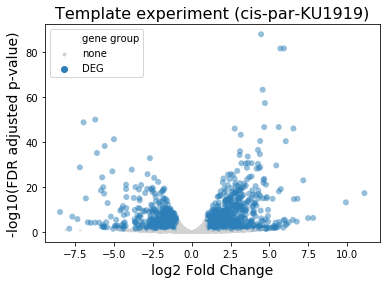

In [17]:
make_volcano_plot_template(
    template_DE_stats_filename,
    project_id,
)

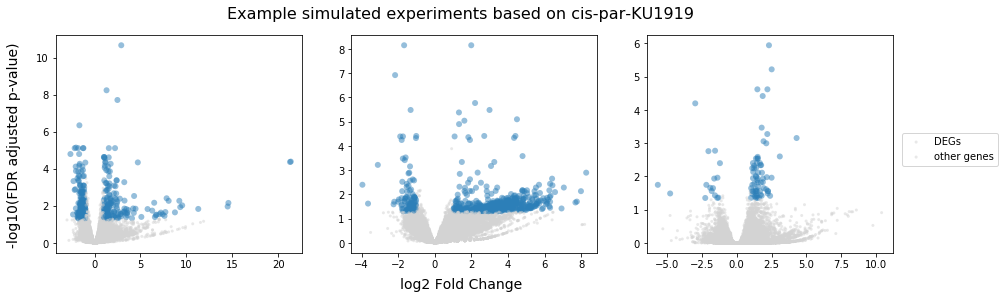

In [18]:
simulated_DE_stats_dir = os.path.join(local_dir, "DE_stats")
num_examples = 3
make_volcano_plot_simulated(
    simulated_DE_stats_dir,
    project_id,
    num_examples
)

## Rank genes

Add description

In [19]:
analysis_type = "DE"
template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
)

## Summary table

TO DO: Description of table columns

Note: If using DESeq, genes with NaN in `Adj P-value (Real)` column are those genes flagged because of the `cooksCutoff` parameter. The cook's distance as a diagnostic to tell if a single sample has a count which has a disproportionate impact on the log fold change and p-values. These genes are flagged with an NA in the pvalue and padj columns of the result table. For more information you can read [DESeq FAQs](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA)

In [20]:
# Get summary table
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    'gene',
    params
)

summary_gene_ranks.sort_values(by="Z score", ascending=False).head(10)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
IDI2,IDI2,5.549812e-18,16352.0,11.117207,11.117207,0.915859,675.0,0.494235,0.986293,25,10.770604
NR2E1,NR2E1,1.998431e-06,16344.0,7.354923,-7.354923,0.871154,10138.0,0.953499,0.804654,16,7.955499
ALG13,ALG13,8.675396e-08,14480.0,1.484572,-1.484572,0.952546,248.0,0.216034,0.177618,25,7.141947
ZNF44,ZNF44,3.681899e-02,16097.0,3.604756,-3.604756,0.884447,4458.0,0.515565,0.445045,25,6.941293
SFT2D3,SFT2D3,1.304459e-01,16349.0,8.118967,-8.118967,0.786029,6299.0,0.959514,1.044915,25,6.851708
ZNF91,ZNF91,3.163924e-19,16319.0,5.842451,-5.842451,0.868815,5413.0,0.710354,0.760801,25,6.745654
CSMD2,CSMD2,1.774135e-15,16338.0,6.806042,6.806042,0.861803,6900.0,0.984916,0.984302,22,5.913964
CYMP,CYMP,4.351338e-03,16312.0,5.682890,-5.682890,0.878766,12827.0,1.109974,0.783585,16,5.835888
LRRC4C,LRRC4C,3.915262e-03,16272.0,4.808832,4.808832,0.812097,5551.0,0.870766,0.682835,18,5.767230
RBBP8,RBBP8,1.876089e-09,15199.0,1.998374,1.998374,0.857144,3341.0,0.473563,0.273204,25,5.581225


In [21]:
summary_gene_ranks.isna().any()

Gene ID                                 False
Adj P-value (Real)                       True
Rank (Real)                             False
abs(log2FoldChange) (Real)              False
log2FoldChange (Real)                   False
Median adj p-value (simulated)          False
Rank (simulated)                        False
Mean abs(log2FoldChange) (simulated)    False
Std deviation (simulated)               False
Number of experiments (simulated)       False
Z score                                 False
dtype: bool

In [22]:
summary_gene_ranks[summary_gene_ranks.isna().any(axis=1)]

,Gene ID,Adj P-value (Real),Rank (Real),abs(log2FoldChange) (Real),log2FoldChange (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(log2FoldChange) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
ECM2,ECM2,NaN,16254.0,4.662405,-4.662405,0.898307,4786.0,0.954868,1.121210,24,3.306728
FLRT1,FLRT1,NaN,16173.0,4.015330,-4.015330,0.671075,11678.0,1.215609,0.916779,25,3.053867
INHBE,INHBE,NaN,16077.0,3.478839,-3.478839,0.721351,15721.0,1.956243,1.501029,21,1.014368
CTH,CTH,NaN,15779.0,2.709156,-2.709156,0.630361,8809.0,1.170625,1.134088,25,1.356624
TRIB3,TRIB3,NaN,15700.0,2.584121,-2.584121,0.752468,7955.0,1.228875,1.674779,25,0.809209


In [23]:
# Save
summary_gene_ranks.to_csv(gene_summary_filename, sep='\t')